## 2023 TBA Predictions

Match data is fetched from TBA by running fetchMatches.py.  Run this first before running this notebook.

`python fetchMatches.py`


In [1]:
from __future__ import print_function
import pickle
#import time
import sys
from collections import Counter
from tqdm import tqdm

sys.path.append('..')
import swagger_client as v3client
from swagger_client.rest import ApiException

# If you fetch_matches best to set reset=True or you may miss some events.
fetch_matches = True
reset = True
year = 2023

if fetch_matches:
    from fetchMatches import fetch_all_matches
    # This will save to matches_{year}.pkl
    fetch_all_matches(year, reset=reset)


Fetching event 2023alhu
Fetching event 2023arli
Fetching event 2023ausc
Fetching event 2023azgl
Fetching event 2023azva
Fetching event 2023bcvi
Fetching event 2023brbr
Fetching event 2023caav
Fetching event 2023cada
Fetching event 2023cafr
Fetching event 2023cala
Fetching event 2023camb
Fetching event 2023caoc
Fetching event 2023caph
Fetching event 2023casd
Fetching event 2023casf
Fetching event 2023casj
Fetching event 2023cave
Fetching event 2023cc
Fetching event 2023chcmp
Fetching event 2023cmptx
Fetching event 2023code
Fetching event 2023cops
Fetching event 2023cthar
Fetching event 2023ctwat
Fetching event 2023flor
Fetching event 2023flta
Fetching event 2023flwp
Fetching event 2023gaalb
Fetching event 2023gacar
Fetching event 2023gacmp
Fetching event 2023gadal
Fetching event 2023gagwi
Fetching event 2023gamac
Fetching event 2023hiho
Fetching event 2023iacf
Fetching event 2023idbo
Fetching event 2023ilch
Fetching event 2023ilpe
Fetching event 2023ilwz
Fetching event 2023incmp
Fetchin

In [2]:
# load all the matches

filename = f'matches_{year}.pkl'
matches = []
with open(filename, 'rb') as f:
    matches = pickle.load(f)

In [3]:
# [m for m in matches['events'] if m.address and 'Spokane' in m.address]
#[m for m in matches['events'] if 'pnc' in m.key]
pnw_district = [m.key for m in matches['events'] if m.district and m.district.abbreviation=='pnw']
pnw_district

['2023orore',
 '2023orsal',
 '2023orwil',
 '2023pncmp',
 '2023waahs',
 '2023wabon',
 '2023wasam',
 '2023wasno',
 '2023wayak']

Filter the matches to completed matches

In [4]:
non_empty = [k for k in matches['matches'].keys() if len(matches['matches'][k])>0]
data = [m for k in matches['matches'] for m in matches['matches'][k]]
data = [m for m in data if m.winning_alliance!='' and m.score_breakdown is not None]
print(f'Found {len(data)} matches')

pnw_teams = set()
for m in [m for m in data if m.event_key in pnw_district]:
    for t in m.alliances.red.team_keys:
        pnw_teams.add(t)
    for t in m.alliances.blue.team_keys:
        pnw_teams.add(t)
    
pnw_teams = list(sorted(pnw_teams))
print(f'PNW Teams: {pnw_teams}')
#red = [x for m in data for x in m.alliances.red.team_keys]
#blue = [x for m in data for x in m.alliances.blue.team_keys]
#from collections import Counter
#Counter(red+blue)

Found 7234 matches
PNW Teams: ['frc1294', 'frc1318', 'frc1359', 'frc1425', 'frc1432', 'frc1540', 'frc1595', 'frc1778', 'frc1899', 'frc1983', 'frc2046', 'frc2097', 'frc2147', 'frc2374', 'frc2412', 'frc2471', 'frc2521', 'frc2522', 'frc2550', 'frc2557', 'frc2635', 'frc2733', 'frc2811', 'frc2898', 'frc2903', 'frc2907', 'frc2910', 'frc2915', 'frc2926', 'frc2928', 'frc2929', 'frc2930', 'frc2976', 'frc2980', 'frc2990', 'frc3024', 'frc3049', 'frc3218', 'frc3219', 'frc3268', 'frc3393', 'frc3588', 'frc360', 'frc3636', 'frc3663', 'frc3673', 'frc3674', 'frc3681', 'frc3711', 'frc3712', 'frc3786', 'frc3826', 'frc3876', 'frc4043', 'frc4060', 'frc4061', 'frc4089', 'frc4104', 'frc4125', 'frc4127', 'frc4131', 'frc4173', 'frc4450', 'frc4469', 'frc4488', 'frc4512', 'frc4513', 'frc4579', 'frc4662', 'frc4681', 'frc4682', 'frc4692', 'frc488', 'frc4911', 'frc4915', 'frc4918', 'frc492', 'frc4980', 'frc5295', 'frc5468', 'frc5588', 'frc568', 'frc5683', 'frc5920', 'frc5937', 'frc5941', 'frc5970', 'frc5975', 'frc6

In [5]:
# Finals, quarterfinales, qualifiers, semifinals
Counter([x.comp_level for x in data])

Counter({'f': 196, 'qm': 5921, 'sf': 1117})

In [6]:
# We'll only train based on qualifier matches

qualifiers = [x for x in data if x.comp_level=='qm'] 

Create aggregate team statistics for all teams, and a separate set for PNW teams

In [7]:

from featurization import addMatch

teamAggregates = {}
pnwAggregates  = {}


import re


for m in qualifiers:    
    for t in m.alliances.red.team_keys:
        addMatch(t, m, teamAggregates)
        if m.event_key in pnw_district:
            addMatch(t, m, pnwAggregates)
    for t in m.alliances.blue.team_keys:
        addMatch(t,m, teamAggregates)
        if m.event_key in pnw_district:
            addMatch(t, m, pnwAggregates)
        
# normalize the aggregates -- TODO: move all this code to featurization.py
def normalize(aggregates):
    for t in aggregates:
        for k in aggregates[t]:
            if k=='totalMatches':
                continue
            aggregates[t][k]/=aggregates[t]['totalMatches']
        aggregates[t]['totalMatches'] = 1.0

normalize(teamAggregates)
normalize(pnwAggregates)

with open('teamStats_2023.pkl','wb') as f:
    pickle.dump(teamAggregates,f)

In [8]:
Counter([m.event_key for m in data if m.event_key in pnw_district])

Counter({'2023orore': 84,
         '2023orwil': 69,
         '2023wabon': 76,
         '2023wasno': 83,
         '2023wayak': 69})

Now we have statistics for every team.  We can use this to generate features for every match.

In [9]:
from featurization import featurizeMatch, invertMatch
features = []

for m in tqdm(data):
    f = featurizeMatch(m, teamAggregates)
    features.append(f)
    #features.append(invertMatch(f))
    


100%|████████████████████████████████████████████████████████████████████████████| 7234/7234 [00:05<00:00, 1298.49it/s]


In [10]:
len(features)

7234

In [11]:
from sklearn.feature_extraction import DictVectorizer
# create train and test sets
train = []
trainY = []
test = []
testY = []

for m in features:    
    if 'event' not in m:
        print(m)
    event = m['event']
    comp_level = m['comp_level']
    del m['event']
    del m['comp_level']
    
    label = m['label']
    del m['label']
    
    # Train on qualifiers. Test on everything else.
    if comp_level!='qm':
        test.append(m)
        testY.append(label)
    else:
        train.append(m)
        trainY.append(label)
        
vectorizer = DictVectorizer()
trainX = vectorizer.fit_transform(train)
testX = vectorizer.transform(test)

print('{} training examples and {} test'.format(len(train),len(test)))


5921 training examples and 1313 test


In [12]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=0, min_samples_split=3)  
classifier.fit(trainX,trainY)
forest_predictions= classifier.predict(testX)
forest_scores = classifier.predict_proba(testX)
import numpy as np
from sklearn.metrics import accuracy_score
#np.sum(np.abs(scores-Ytest))
print('accuracy: {}'.format(accuracy_score(testY, forest_predictions)))
#list(zip(forest_scores[:,1],testY))

# Save the model
model_fn = 'model_2023_forest.pkl'
with open(model_fn, 'wb') as outF:
    pickle.dump((vectorizer,classifier), outF)


accuracy: 0.6953541507996953


Let's look at the feature importances. They tell us how useful a specific feature is.

Feature ranking:


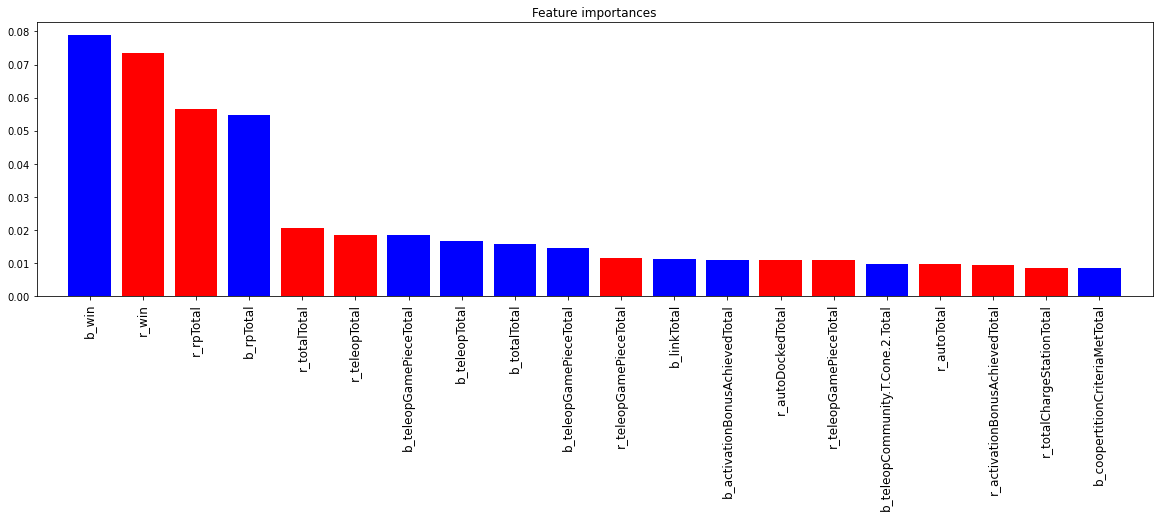

In [13]:
topN = 20
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:topN]
names = vectorizer.feature_names_

# Print the feature ranking
print("Feature ranking:")

#for f in range(trainX.shape[1]):
#    print("%d. %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))
colors = [names[indices[f]].split('_')[0] for f in range(topN)]
labels = [names[indices[f]].replace('Count','').replace('Points','').replace('red','r').replace('blue','b') for f in range(topN)]
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
plt.figure()
plt.title("Feature importances")
plt.bar(range(topN), importances[indices],
       color=colors, 
        #yerr=std[indices], 
        align="center")
plt.xticks(range(topN), labels, rotation='vertical', fontsize='large')
    
plt.xlim([-1, topN])
plt.subplots_adjust(bottom=0.5)
#plt.legend()
plt.show()

In [14]:
def percentile(dictionary, key):
    teams = [t for t in dictionary]
    values = [dictionary[t][key] for t in dictionary]
    ranks = sorted(range(len(values)), key=lambda x: values[x])
    return dict([(teams[ranks[i]], i*100/len(values)) for i in range(len(ranks))])    

raw = dict([(k, percentile(teamAggregates,k)) for k in teamAggregates['frc1153']])
#stats = dict([(k,percentile(teamAggregates,k)['frc1153']) for k in teamAggregates['frc1153']])

The next cell enables comparisons between two teams.

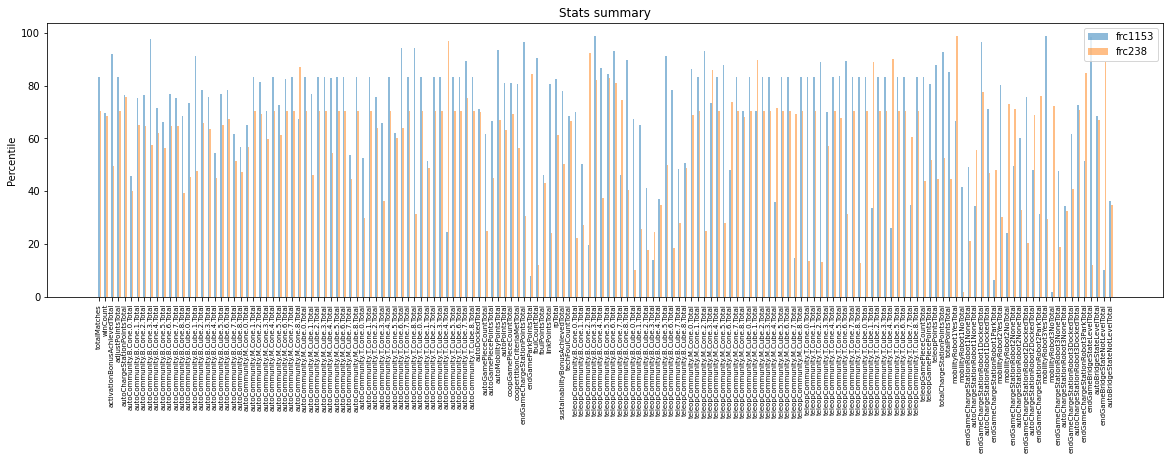

In [28]:
import matplotlib.pyplot as plt
import numpy as np

objects = [k for k in raw]
y_pos = np.arange(len(objects))
#performance = [[raw[k]['frc492'],raw[k]['frc2910']] for k in stats]
#performance
t1 = 'frc1153'
t2 = 'frc238'
plt.figure()
plt.bar(y_pos, [raw[k][t1] for k in raw], alpha=0.5, width=0.25)
plt.bar(y_pos+0.25, [raw[k][t2] for k in raw], alpha=0.5, width=0.25)
plt.xticks(y_pos, objects, rotation=90, fontsize='x-small')
plt.subplots_adjust(bottom=0.5)
plt.ylabel('Percentile')
plt.title('Stats summary')
plt.legend([t1,t2])

plt.show()


So far our best score at predicting the districts is about 70% using RandomForests.  Next time we can explore hyperparameter tuning and also predicting which alliances would have been the best ones for us to join.

Next steps: for a given event we want to decide how to prioritize alliance choices.  Suppose we have all the data to date, as well as all the qualifier data for the event. Who should we choose as partners?

In [16]:
# optimize alliances for {target_id} at {event} on second pick:
import random
from tqdm import tqdm
from featurization import featurizeAlliances
from itertools import combinations

event = '2023wayak'
target_id = 492
teams = set([t for x in \
    [m.alliances.red.team_keys + m.alliances.blue.team_keys for m in matches['matches'][event]] \
        for t in x])
print(f'There are {len(teams)} teams at this event')

model_fn = 'model_2023_forest.pkl'
with open(model_fn, 'rb') as inF:
    vectorizer, model = pickle.load(inF)

# wasno
taken_wasno = [
    #2910, 2930, 7627, 488, 4911, # 4915, 1318, 2522 -- for 4911 on their first pick.
    2910, 4131, 6443, 1595, 2811, 5920, 5468, 492, 2147, 1318, 955, 3711, 7461, 4061, 4980
]


taken = list(map(lambda x: f'frc{x}', taken_wasno))

# set to just ['frc492'] if you're ranking pairs
target = [f'frc{target_id}']
# target = ['frc492', 'frc1899']

# If you are ranking pairs
if len(target)==1:
    partners = [[x,y] for x in teams if x!=target for y in teams if y!=target if x<y and x not in taken and y not in taken]
else:
    partners = [[x] for x in teams if x not in taken]
results = {}
features = []
alliances = []
trials = 500 

# iterate through all the potential pairs of partners. 
# For each pair, we sample {trials} opponent alliances and assess whether we think they will win.
for p in tqdm(partners): 
    red = target + p  
    candidates = [x for x in teams if x not in red]
    
    # Run trials sampling blue alliances from the remaining teams.
    # Here we're sampling any possible alliance, except the members of red.
    # We just run {trials} samples because a typical event has about 34 teams, which would yield 
    # more than 5000 alliances, requiring more than 2 million match predictions in total
    
    for m in range(trials):
        blue = random.sample(candidates, 3)
        f = featurizeAlliances(teamAggregates, red, blue)
        features.append(f)
        alliances.append([red,blue])

# run all the simulated matches through the model
print(f"Running {len(features)} predictions")
scores = model.predict_proba(vectorizer.transform(features))
results = {}
for (p,_), score in zip(alliances, scores): 
    p = tuple(p)
    if p not in results:
        results[p] = 0
    results[p] += score[1]    


for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(r, results[r]*100/trials)

There are 27 teams at this event


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:24<00:00,  2.71it/s]


Running 33000 predictions
('frc492', 'frc2926', 'frc8532') 54.25848333333331
('frc492', 'frc4060', 'frc8532') 50.45009999999992
('frc492', 'frc2926', 'frc4060') 47.83176666666667
('frc492', 'frc4513', 'frc8532') 47.01335000000001
('frc492', 'frc2926', 'frc4513') 46.70484999999999
('frc492', 'frc3826', 'frc8532') 45.9664333333333
('frc492', 'frc2926', 'frc3826') 45.89368333333334
('frc492', 'frc2926', 'frc4692') 45.43391666666666
('frc492', 'frc4060', 'frc4692') 44.395033333333345
('frc492', 'frc4692', 'frc8532') 43.59631666666665
('frc492', 'frc4060', 'frc4513') 42.81433333333332
('frc492', 'frc3826', 'frc4060') 41.9713333333333
('frc492', 'frc3826', 'frc4692') 38.68586666666666
('frc492', 'frc4513', 'frc4692') 38.349333333333306
('frc492', 'frc6831', 'frc8532') 37.83790000000001
('frc492', 'frc3826', 'frc4513') 37.284033333333404
('frc492', 'frc2926', 'frc3876') 36.541783333333335
('frc492', 'frc2926', 'frc6831') 36.35723333333334
('frc492', 'frc3876', 'frc8532') 34.7104166666667
('fr

In [17]:
# Districts
import random
from tqdm import tqdm

# Districts event key is '2022pncmp': update this on Friday night
#event = '2022pncmp'
event = '2023wayak'

# Fetch the event rankings so far.
from fetchMatches import fetch_event_rankings
rankings = fetch_event_rankings(event)

print([(r.rank, r.team_key) for r in rankings.rankings])
teams = [r.team_key for r in rankings.rankings]

rank_492 = [r.rank for r in rankings.rankings if r.team_key==f'frc{target_id}'][0]
prior_taken = teams[:rank_492]
print(prior_taken)
teams_ahead = rank_492-1
all_taken = teams[:rank_492+teams_ahead]
print(all_taken)

rankings_dict = dict([(r.team_key, r.rank) for r in rankings.rankings])

[(1, 'frc2910'), (2, 'frc2147'), (3, 'frc4131'), (4, 'frc6443'), (5, 'frc955'), (6, 'frc1595'), (7, 'frc3711'), (8, 'frc1318'), (9, 'frc2811'), (10, 'frc5920'), (11, 'frc5468'), (12, 'frc4061'), (13, 'frc492'), (14, 'frc7461'), (15, 'frc2926'), (16, 'frc4513'), (17, 'frc3826'), (18, 'frc4980'), (19, 'frc4060'), (20, 'frc4104'), (21, 'frc3712'), (22, 'frc4692'), (23, 'frc3876'), (24, 'frc8532'), (25, 'frc6831'), (26, 'frc4125'), (27, 'frc6076')]
['frc2910', 'frc2147', 'frc4131', 'frc6443', 'frc955', 'frc1595', 'frc3711', 'frc1318', 'frc2811', 'frc5920', 'frc5468', 'frc4061', 'frc492']
['frc2910', 'frc2147', 'frc4131', 'frc6443', 'frc955', 'frc1595', 'frc3711', 'frc1318', 'frc2811', 'frc5920', 'frc5468', 'frc4061', 'frc492', 'frc7461', 'frc2926', 'frc4513', 'frc3826', 'frc4980', 'frc4060', 'frc4104', 'frc3712', 'frc4692', 'frc3876', 'frc8532', 'frc6831']


In [19]:
# This cell continues with the event key set above.

teams = set([t for x in \
    [m.alliances.red.team_keys + m.alliances.blue.team_keys for m in matches['matches'][event]] \
        for t in x])
print(teams)
model_fn = 'model_2023_forest.pkl'
with open(model_fn, 'rb') as inF:
    vectorizer, model = pickle.load(inF)

# Set to include only 492 when we just want to rank all the potential alliances.
taken = [
    target_id
]


taken = list(map(lambda x: f'frc{x}', taken))

# set to just ['frc492'] if you're ranking pairs, ['frc492', 'first choice partner'] if you want to rank second choices.
target = [f'frc{target_id}']
# target = ['frc492', 'frc1899']

# If you are ranking pairs
if len(target)==1:
    partners = [[x,y] for x in teams if x!=target for y in teams if y!=target if x<y and x not in taken and y not in taken]
else:
    partners = [[x] for x in teams if x not in taken]
results = {}
features = []
alliances = []
trials = 1000
for p in tqdm(partners): 
    red = target + p  
    candidates = [x for x in teams if x not in red]
    
    for m in range(trials):
        # Here we're sampling any possible alliance, except the members of red.    
        blue = random.sample(candidates, 3)
        f = featurizeAlliances(teamAggregates, red, blue)
        features.append(f)
        alliances.append([red,blue])

# run all the simulated matches through the model
scores = model.predict_proba(vectorizer.transform(features))
results = {}
for (p,_), score in zip(alliances, scores): 
    p = tuple(p)
    if p not in results:
        results[p] = 0
    results[p] += score[1]    

for p in results:
    results[p] = results[p] * 100 / trials

for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(r, results[r])

  0%|                                                                                          | 0/325 [00:00<?, ?it/s]

{'frc7461', 'frc4061', 'frc6443', 'frc4104', 'frc4125', 'frc3826', 'frc4060', 'frc6076', 'frc5468', 'frc4692', 'frc2811', 'frc3711', 'frc8532', 'frc5920', 'frc492', 'frc2910', 'frc955', 'frc1595', 'frc6831', 'frc1318', 'frc3712', 'frc4513', 'frc4980', 'frc3876', 'frc4131', 'frc2926', 'frc2147'}


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [03:55<00:00,  1.38it/s]


('frc492', 'frc2147', 'frc955') 81.24183333333356
('frc492', 'frc2147', 'frc2910') 81.22191666666677
('frc492', 'frc2910', 'frc955') 81.1941
('frc492', 'frc1318', 'frc2910') 81.13791666666678
('frc492', 'frc2910', 'frc4131') 80.67711666666656
('frc492', 'frc2910', 'frc3711') 80.41599999999995
('frc492', 'frc2910', 'frc4513') 79.92028333333339
('frc492', 'frc2910', 'frc6443') 79.91083333333336
('frc492', 'frc2910', 'frc4980') 79.75003333333345
('frc492', 'frc2910', 'frc2926') 79.6045833333335
('frc492', 'frc2910', 'frc5920') 79.56646666666673
('frc492', 'frc1595', 'frc2910') 79.50251666666678
('frc492', 'frc2910', 'frc4060') 79.25597500000013
('frc492', 'frc2910', 'frc8532') 79.02659999999996
('frc492', 'frc2147', 'frc3711') 78.97663333333347
('frc492', 'frc2147', 'frc7461') 78.94035000000004
('frc492', 'frc2910', 'frc4061') 78.83118333333358
('frc492', 'frc1318', 'frc2147') 78.8275333333336
('frc492', 'frc2811', 'frc2910') 78.4635
('frc492', 'frc2910', 'frc6831') 78.36760000000015
('fr

In [ ]:

with open('alliance_rankings.csv', 'w', encoding='utf-8') as outF:
    outF.write('a1,a2,a3,p(win),rank1,rank2,rank3\n')
    for (a1,a2,a3) in list(sorted(results, key=lambda x: results[x], reverse=True)):
        outF.write('{},{},{},{},{},{},{}\n'.format(a1,a2,a3,results[(a1,a2,a3)], rankings_dict[a1], rankings_dict[a2], rankings_dict[a3]))

ranks = {}
for r in results:
    for a in r[1:]:
        if a not in ranks:
            ranks[a] = 0
        ranks[a]+=results[r]
with open('team_rankings.csv', 'w', encoding='utf-8') as outF:
    outF.write('team,score,pnw_rank\n')
    for a in sorted(ranks, key=lambda x: ranks[x], reverse=True):
        outF.write('{},{},{}\n'.format(a,ranks[a], rankings_dict[a]))


In [ ]:
# One more using only districts stats
# This cell continues with the event key set above.

teams = set([t for x in \
    [m.alliances.red.team_keys + m.alliances.blue.team_keys for m in matches['matches'][event]] \
        for t in x])
print(teams)
model_fn = 'model_2023_forest.pkl'
with open(model_fn, 'rb') as inF:
    vectorizer, model = pickle.load(inF)

# Set to include only 492 when we just want to rank all the potential alliances.
taken = [
    target_id
]


taken = list(map(lambda x: f'frc{x}', taken))

# set to just ['frc492'] if you're ranking pairs, ['frc492', 'first choice partner'] if you want to rank second choices.
target = [f'frc{target_id}']
# target = ['frc492', 'frc1899']

# If you are ranking pairs
if len(target)==1:
    partners = [[x,y] for x in teams if x!=target for y in teams if y!=target if x<y and x not in taken and y not in taken]
else:
    partners = [[x] for x in teams if x not in taken]
results = {}
features = []
alliances = []
trials = 1000
for p in tqdm(partners): 
    red = target + p  
    candidates = [x for x in teams if x not in red]
    
    for m in range(trials):
        # Here we're sampling any possible alliance, except the members of red.    
        blue = random.sample(candidates, 3)
        f = featurizeAlliances(red, blue, pnwAggregates)
        features.append(f)
        alliances.append([red,blue])

# run all the simulated matches through the model
scores = model.predict_proba(vectorizer.transform(features))
results = {}
for (p,_), score in zip(alliances, scores): 
    p = tuple(p)
    if p not in results:
        results[p] = 0
    results[p] += score[1]    

for p in results:
    results[p] = results[p] * 100 / trials

for r in list(sorted(results, key=lambda x: results[x], reverse=True))[:100]:
    print(r, results[r])

In [ ]:

with open('pnw_alliance_rankings.csv', 'w', encoding='utf-8') as outF:
    outF.write('a1,a2,a3,p(win),rank1,rank2,rank3\n')
    for (a1,a2,a3) in list(sorted(results, key=lambda x: results[x], reverse=True)):
        outF.write('{},{},{},{},{},{},{}\n'.format(a1,a2,a3,results[(a1,a2,a3)], rankings_dict[a1], rankings_dict[a2], rankings_dict[a3]))

ranks = {}
for r in results:
    for a in r[1:]:
        if a not in ranks:
            ranks[a] = 0
        ranks[a]+=results[r]
with open('pnw_team_rankings.csv', 'w', encoding='utf-8') as outF:
    outF.write('team,score,pnw_rank\n')
    for a in sorted(ranks, key=lambda x: ranks[x], reverse=True):
        outF.write('{},{},{}\n'.format(a,ranks[a], rankings_dict[a]))

In [26]:
# Brackets
import random 
model_fn = 'model_2023_forest.pkl'
with open(model_fn, 'rb') as inF:
    vectorizer, model = pickle.load(inF)

wins = Counter()

trials = 1000
for t in tqdm(range(trials)):
    # TODO: download from TBA
    brackets = list(map(lambda x: list(map(lambda y: f'frc{y}', x)),
        [
            (4911, 2910, 3218),
            (2990, 955, 360),
            (5827, 2147, 2557),
            (4089, 1595, 3663),
            (2046, 2976, 488),
            (7034, 997, 1899),
            (4488, 2471, 2522),
            (3636, 2930, 3674)
        ]))

    while len(brackets)>1:
        alliances = []
        features = []
        for x in range(0,len(brackets),2):
            red = brackets[x]
            blue = brackets[x+1]
            #print(red,blue)
            f = featurizeAlliances(red, blue, aggregates=teamAggregates)       
            features.append(f)
            alliances.append([red,blue])

        # run all the simulated matches through the model
        scores = model.predict_proba(vectorizer.transform(features))
        results = {}
        next_round = []
        for (r,b), score in zip(alliances, scores): 
            #print(r,b,score)
            #if score[1]>score[0]:
            if random.random()<score[1]:
                next_round.append(r)
            else:
                next_round.append(b)
        brackets = next_round
        #print(brackets)
    wins[tuple(brackets[0])]+=1
for x in sorted(wins, reverse=True, key=lambda x: wins[x]):
    print(f'{tuple(map(lambda y: y[3:], x))} {wins[x]/10}%')

100%|██████████| 1000/1000 [00:27<00:00, 35.76it/s]

('3636', '2930', '3674') 26.8%
('4911', '2910', '3218') 14.1%
('4488', '2471', '2522') 13.9%
('2990', '955', '360') 12.9%
('2046', '2976', '488') 11.9%
('5827', '2147', '2557') 8.4%
('4089', '1595', '3663') 8.2%
('7034', '997', '1899') 3.8%
